In [5]:
from IPython.display import Image
%matplotlib inline

In [6]:
# Added version check for recent scikit-learn 0.18 checks
from distutils.version import LooseVersion as Version
from sklearn import __version__ as sklearn_version

# 第5章 次元削減でデータを圧縮する

## 本章で扱う内容
- 教師なしデータ圧縮での主成分分析（PCA） 
- クラスの分離を最大化する教師あり次元削減法としての線形判別分析（LDA）
- カーネル主成分分析による非線形次元削減

## 5.1 主成分分析による教師なし次元削減
---

### 特徴選択と特徴抽出の違い
- 特徴選択: 元の特徴量は変換されることなくそのままの形で維持される
- 特徴抽出: データが新しい特徴空間に変換または射影される

### 主成分分析（Principal Component Analysis: PCA）
- 特徴量どうしの相関関係に基づいてデータからパターンを抽出する
- 高次元データにおいて分散が最大となる方向を見つけ出し、元の次元と同じかそれよりも低い次元の新しい部分空間へ射影する
- 新しい部分空間の直交軸（主成分）を分散が最大となる方向と見なすことができる
- すべての特徴量に等しい重要度を割り当てたい場合は、PCAの前に特徴量を標準化する必要がある

<img src="./images/05_01.png">

#### 次元削減のためのPCA で行うこと
1. *d*次元のデータセットを標準化する
2. 標準化したデータセットの共分散行列（covariance matrix）を作成する
3. 共分散行列を固有ベクトルと固有値に分解する
4. 最も大きい*k*個の固有値に対応するk個の固有ベクトルを選択する（*k* ≤ *d*）
5. 上位*k*個の固有ベクトルから射影行列**_W_**を作成する
6. 射影行列**_W_**を使って*d*次元の入力データセット**_X_**を変換し、新しい*k*次元の特徴部分空間を取得する

## 5.1.1 共分散行列の固有対を求める
---

Wine データセットをロードする

In [7]:
import pandas as pd

df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/'
                      'machine-learning-databases/wine/wine.data',
                      header=None)

df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue',
                   'OD280/OD315 of diluted wines', 'Proline']

df_wine.head()

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


Wine データセットをトレーニングデータセット(70%)とテストデータセット（30%）に分割する

In [8]:
if Version(sklearn_version) < '0.18':
    from sklearn.cross_validation import train_test_split
else:
    from sklearn.model_selection import train_test_split

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [31]:
help(train_test_split)

Help on function train_test_split in module sklearn.model_selection._split:

train_test_split(*arrays, **options)
    Split arrays or matrices into random train and test subsets
    
    Quick utility that wraps input validation and
    ``next(ShuffleSplit().split(X, y))`` and application to input data
    into a single call for splitting (and optionally subsampling) data in a
    oneliner.
    
    Read more in the :ref:`User Guide <cross_validation>`.
    
    Parameters
    ----------
    *arrays : sequence of indexables with same length / shape[0]
        Allowed inputs are lists, numpy arrays, scipy-sparse
        matrices or pandas dataframes.
    
    test_size : float, int, or None (default is None)
        If float, should be between 0.0 and 1.0 and represent the
        proportion of the dataset to include in the test split. If
        int, represents the absolute number of test samples. If None,
        the value is automatically set to the complement of the train size.
    

分散が1となるように標準化する

In [25]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)
help(StandardScaler.fit_transform)
help(StandardScaler.transform)

Help on function fit_transform in module sklearn.base:

fit_transform(self, X, y=None, **fit_params)
    Fit to data, then transform it.
    
    Fits transformer to X and y with optional parameters fit_params
    and returns a transformed version of X.
    
    Parameters
    ----------
    X : numpy array of shape [n_samples, n_features]
        Training set.
    
    y : numpy array of shape [n_samples]
        Target values.
    
    Returns
    -------
    X_new : numpy array of shape [n_samples, n_features_new]
        Transformed array.

Help on function transform in module sklearn.preprocessing.data:

transform(self, X, y=None, copy=None)
    Perform standardization by centering and scaling
    
    Parameters
    ----------
    X : array-like, shape [n_samples, n_features]
        The data used to scale along the features axis.



Numpyのlinalg.eig 関数を使って、Wine データセットの共分散行列の固有対（eigenpair: 固有値と固有ベクトル）を取得する

In [26]:
import numpy as np
cov_mat = np.cov(X_train_std.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

print('\nEigenvalues \n%s' % eigen_vals)


Eigenvalues 
[ 4.8923083   2.46635032  1.42809973  1.01233462  0.84906459  0.60181514
  0.52251546  0.08414846  0.33051429  0.29595018  0.16831254  0.21432212
  0.2399553 ]


In [30]:
help(np.cov)
help(np.linalg.eig)

Help on function cov in module numpy.lib.function_base:

cov(m, y=None, rowvar=True, bias=False, ddof=None, fweights=None, aweights=None)
    Estimate a covariance matrix, given data and weights.
    
    Covariance indicates the level to which two variables vary together.
    If we examine N-dimensional samples, :math:`X = [x_1, x_2, ... x_N]^T`,
    then the covariance matrix element :math:`C_{ij}` is the covariance of
    :math:`x_i` and :math:`x_j`. The element :math:`C_{ii}` is the variance
    of :math:`x_i`.
    
    See the notes for an outline of the algorithm.
    
    Parameters
    ----------
    m : array_like
        A 1-D or 2-D array containing multiple variables and observations.
        Each row of `m` represents a variable, and each column a single
        observation of all those variables. Also see `rowvar` below.
    y : array_like, optional
        An additional set of variables and observations. `y` has the same form
        as that of `m`.
    rowvar : bool, op

データセットを新しい特徴部分空間に圧縮するため、データに含まれる大半の情報（分散）を含んでいる固有ベクトル（主成分）だけを選択する

In [34]:
tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

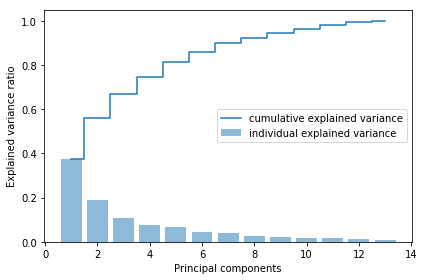

In [39]:
import matplotlib.pyplot as plt


plt.bar(range(1, 14), var_exp, alpha=0.5, align='center',
        label='individual explained variance')
plt.step(range(1, 14), cum_var_exp, where='mid',
         label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

上位2つの主成分で全体の約60%を占めていることがわかる

### 5.1.2 特徴変換
---

Wineデータセットを新しい主成分軸に変換する
- 固有値の大きいものから順に固有対を並べ替え、選択された固有ベクトルから射影行列を生成する
- 求めた射影行列を使ってデータをより低い次元の部分空間に変換する

まず、固有値の大きいものから順に固有対を並べ替える

In [41]:
# Make a list of (eigenvalue, eigenvector) tuples
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i])
               for i in range(len(eigen_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eigen_pairs.sort(key=lambda k: k[0], reverse=True)

# Note: I added the `key=lambda k: k[0]` in the sort call above
# just like I used it further below in the LDA section.
# This is to avoid problems if there are ties in the eigenvalue
# arrays (i.e., the sorting algorithm will only regard the
# first element of the tuples, now).

次に、最も大きい2つの固有値に対応する2つの固有ベクトルを集める

**普通にhstackをするとうまくいかない**

In [43]:
w = np.hstack((eigen_pairs[0][1],
               eigen_pairs[1][1]))
print('Matrix W:\n', w)

Matrix W:
 [ 0.14669811 -0.24224554 -0.02993442 -0.25519002  0.12079772  0.38934455
  0.42326486 -0.30634956  0.30572219 -0.09869191  0.30032535  0.36821154
  0.29259713  0.50417079  0.24216889  0.28698484 -0.06468718  0.22995385
  0.09363991  0.01088622  0.01870216  0.03040352  0.54527081 -0.27924322
 -0.174365    0.36315461]


**np.newaxisを使い明示的に列ベクトルを生成する必要がある**

In [45]:
w = np.hstack((eigen_pairs[0][1][:, np.newaxis],
               eigen_pairs[1][1][:, np.newaxis]))
print('Matrix W:\n', w)

Matrix W:
 [[ 0.14669811  0.50417079]
 [-0.24224554  0.24216889]
 [-0.02993442  0.28698484]
 [-0.25519002 -0.06468718]
 [ 0.12079772  0.22995385]
 [ 0.38934455  0.09363991]
 [ 0.42326486  0.01088622]
 [-0.30634956  0.01870216]
 [ 0.30572219  0.03040352]
 [-0.09869191  0.54527081]
 [ 0.30032535 -0.27924322]
 [ 0.36821154 -0.174365  ]
 [ 0.29259713  0.36315461]]


得られた上位2つの固有ベクトルから作成された13×2次元の射影行列**_W_**を使って、サンプル**_x_**をPCAの部分空間に変換し、2つの新しい特徴量からなる2次元のサンプルベクトル**_x'_**を生成する

In [46]:
X_train_std[0].dot(w)

array([ 2.59891628,  0.00484089])

行列の積を計算することにより、124×13次元のトレーニングデータセット全体を2つの主成分に変換する

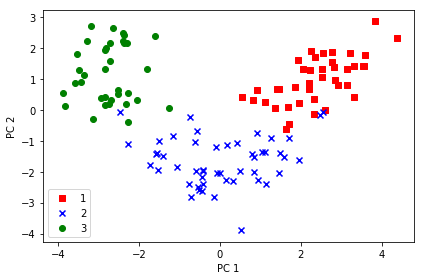

In [49]:
X_train_pca = X_train_std.dot(w)
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']

for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train == l, 0], 
                X_train_pca[y_train == l, 1], 
                c=c, label=l, marker=m)

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

X軸、Y軸のばらつきを見ると、1つ目の主成分であるX軸の方が2つ目の主成分であるY軸よりもばらついている

### 5.1.3 scikit-learnの主成分分析
---

scikit-learn のPCAを用いて5.1.2と同様のことを行う

In [50]:
from sklearn.decomposition import PCA

pca = PCA()
X_train_pca = pca.fit_transform(X_train_std)
pca.explained_variance_ratio_

array([ 0.37329648,  0.18818926,  0.10896791,  0.07724389,  0.06478595,
        0.04592014,  0.03986936,  0.02521914,  0.02258181,  0.01830924,
        0.01635336,  0.01284271,  0.00642076])

In [53]:
help(PCA)

Help on class PCA in module sklearn.decomposition.pca:

class PCA(sklearn.decomposition.base._BasePCA)
 |  Principal component analysis (PCA)
 |  
 |  Linear dimensionality reduction using Singular Value Decomposition of the
 |  data to project it to a lower dimensional space.
 |  
 |  It uses the LAPACK implementation of the full SVD or a randomized truncated
 |  SVD by the method of Halko et al. 2009, depending on the shape of the input
 |  data and the number of components to extract.
 |  
 |  It can also use the scipy.sparse.linalg ARPACK implementation of the
 |  truncated SVD.
 |  
 |  Notice that this class does not support sparse input. See
 |  :class:`TruncatedSVD` for an alternative with sparse data.
 |  
 |  Read more in the :ref:`User Guide <PCA>`.
 |  
 |  Parameters
 |  ----------
 |  n_components : int, float, None or string
 |      Number of components to keep.
 |      if n_components is not set all components are kept::
 |  
 |          n_components == min(n_samples, n

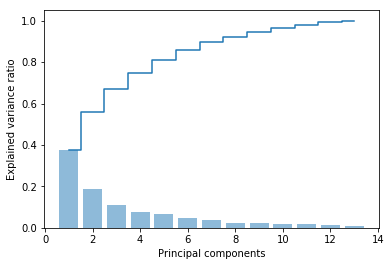

In [54]:
plt.bar(range(1, 14), pca.explained_variance_ratio_, alpha=0.5, align='center')
plt.step(range(1, 14), np.cumsum(pca.explained_variance_ratio_), where='mid')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.show()

Wineデータセットでscikit-learnのPCAクラスを使用し、ロジスティック回帰を使って変換後のサンプルを分類する

In [56]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

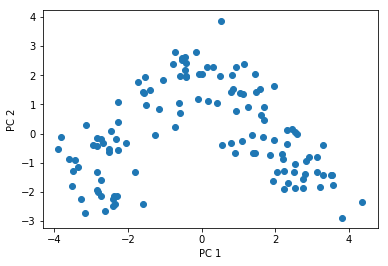

In [57]:
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1])
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()

第2章で定義した決定領域プロット関数

In [58]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, c=cmap(idx),
                    marker=markers[idx], label=cl)

ロジスティック回帰を行う

In [60]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr = lr.fit(X_train_pca, y_train)

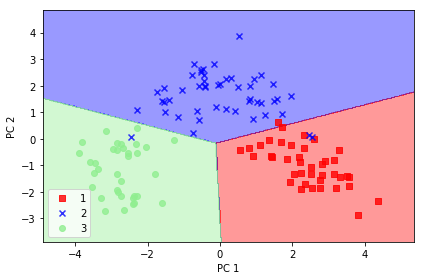

In [61]:
plot_decision_regions(X_train_pca, y_train, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()